In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import cv2
import mediapipe as mp
from imblearn.under_sampling import RandomUnderSampler
from scipy.ndimage import shift
from sklearn.metrics import confusion_matrix

In [2]:
data_blink = np.load('dataset/ujicoba_1/Blinks_30_All.npy')
label = np.load('dataset/ujicoba_1/Labels_30_All.npy')
data_blink.shape

(27635, 30, 4)

Setiap data berisi 30x4 matriks yang memiliki arti 30 baris adalah 30 kedipan dan 4 kolom adalah 4 komponen dari kedipan.

Berdasarkan Code dari GitHub urutan fitur yaitu: </br>
<li>0 = Freq</li>
<li>1 = Amp</li>
<li>2 = Dur</li>
<li>3 = Velocity</li>

In [3]:
lbl = list(np.unique(label))
for cl in lbl:
    encode = lbl.index(cl)
    idk_lbl = label == cl
    label[idk_lbl.flatten()] = encode
label = label.astype(int)
np.unique(label)

array([0, 1, 2])

# Eksplorasi

In [4]:
idk_alert = label == 0
alert_data_30 = data_blink[idk_alert.flatten()]
idk_rodok = label == 1
rodok_data_30 = data_blink[idk_rodok.flatten()]
idk_drow = label == 2
drow_data_30 = data_blink[idk_drow.flatten()]

Disini kami melakukan pemecehan data perkelas. Hal ini bertujuan untuk melihat apakah ada perbedaan yang sangat jelas dari masing-masing kelas.

In [5]:
alert_data = alert_data_30.reshape((alert_data_30.shape[0]*30, 4))
rodok_data = rodok_data_30.reshape((rodok_data_30.shape[0]*30, 4))
drow_data = drow_data_30.reshape((drow_data_30.shape[0]*30, 4))

Data yang sudah dipecah perkelas tadi, kami ubah bentuknya menjadi (30*(banyak data) x 4). Intinya kedipan yang dikelompokkan per 30 tadi kami jadikan 1.

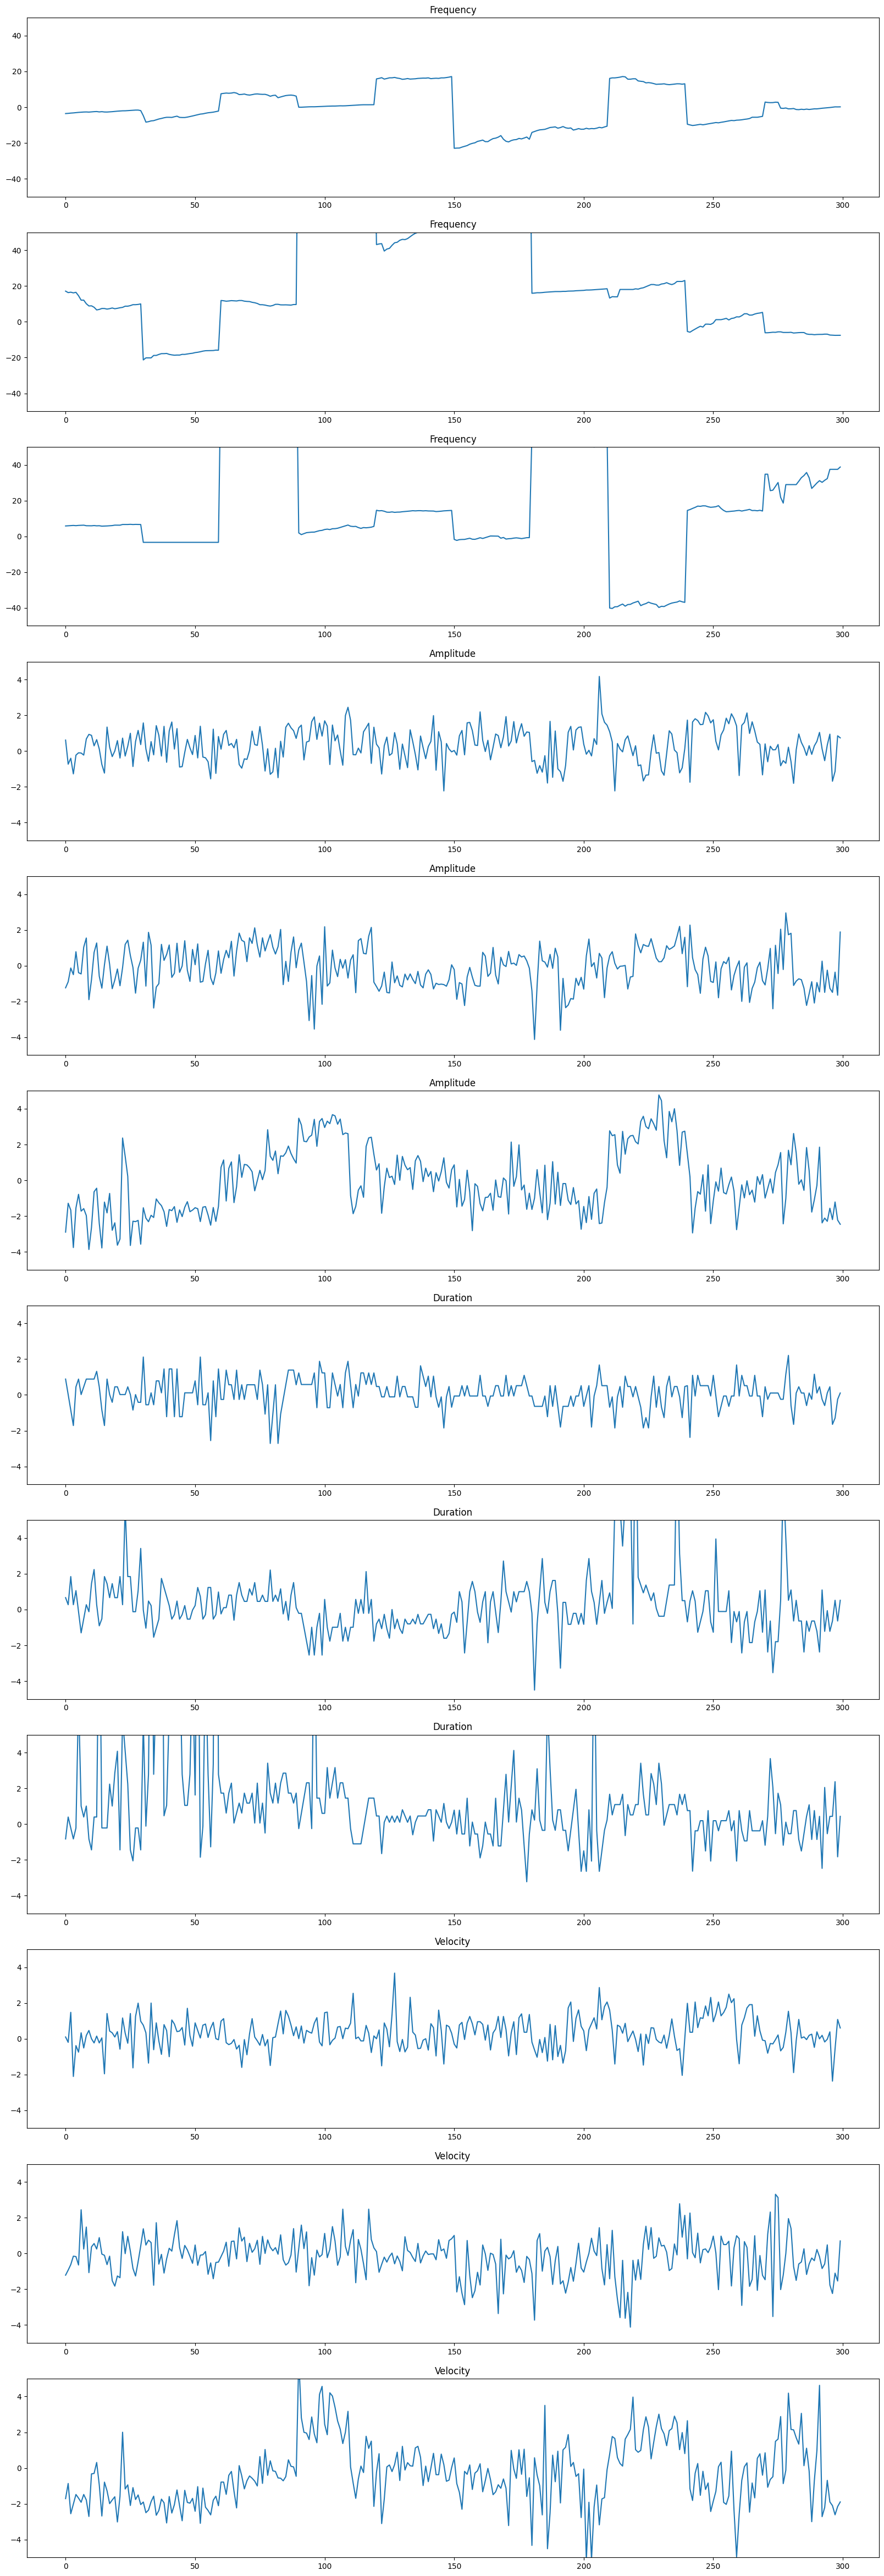

In [7]:
panjang = 300

fig, axs = plt.subplots(12, 1, figsize=(20, 60))

start_alert = np.random.randint(0, ((alert_data.shape[0]//30) - 300)) * 30
end_alert = start_alert + 300

axs[(3*0)].plot(alert_data[start_alert:end_alert, 0])
axs[(3*0)].set_ylim(-50, 50)
axs[(3*0)].set_title('Frequency')

axs[(3*1)].plot(alert_data[start_alert:end_alert, 1])
axs[(3*1)].set_ylim(-5, 5)
axs[(3*1)].set_title('Amplitude')

axs[(3*2)].plot(alert_data[start_alert:end_alert, 2])
axs[(3*2)].set_ylim(-5, 5)
axs[(3*2)].set_title('Duration')

axs[(3*3)].plot(alert_data[start_alert:end_alert, 3])
axs[(3*3)].set_ylim(-5, 5)
axs[(3*3)].set_title('Velocity')


start_rodok = np.random.randint(0, ((rodok_data.shape[0]//30) - 300)) * 30
end_rodok = start_rodok + 300

axs[(3*0)+1].plot(rodok_data[start_rodok:end_rodok, 0])
axs[(3*0)+1].set_ylim(-50, 50)
axs[(3*0)+1].set_title('Frequency')

axs[(3*1)+1].plot(rodok_data[start_rodok:end_rodok, 1])
axs[(3*1)+1].set_ylim(-5, 5)
axs[(3*1)+1].set_title('Amplitude')

axs[(3*2)+1].plot(rodok_data[start_rodok:end_rodok, 2])
axs[(3*2)+1].set_ylim(-5, 5)
axs[(3*2)+1].set_title('Duration')

axs[(3*3)+1].plot(rodok_data[start_rodok:end_rodok, 3])
axs[(3*3)+1].set_ylim(-5, 5)
axs[(3*3)+1].set_title('Velocity')


start_rodok = np.random.randint(0, ((drow_data.shape[0]//30) - 300)) * 30
end_rodok = start_rodok + 300

axs[(3*0)+2].plot(drow_data[start_rodok:end_rodok, 0])
axs[(3*0)+2].set_ylim(-50, 50)
axs[(3*0)+2].set_title('Frequency')

axs[(3*1)+2].plot(drow_data[start_rodok:end_rodok, 1])
axs[(3*1)+2].set_ylim(-5, 5)
axs[(3*1)+2].set_title('Amplitude')

axs[(3*2)+2].plot(drow_data[start_rodok:end_rodok, 2])
axs[(3*2)+2].set_ylim(-5, 5)
axs[(3*2)+2].set_title('Duration')

axs[(3*3)+2].plot(drow_data[start_rodok:end_rodok, 3])
axs[(3*3)+2].set_ylim(-5, 5)
axs[(3*3)+2].set_title('Velocity')


plt.show()

**Insight**</br>
Dari hasil beberapa kali running (pengmbilan 300 data secara random), kami berasumsi bahwa adanya perbedaan antara alert (tidak mengantuk) dengan 2 class LV (Low-Vigilan) dan drowsy. Perbedaan tersebut terlihat pada fluktuasi dari fitur durasi, amplitudo, dan velocity yang cukup berbeda, dimana alert cenderung lebih stabil jikka dibanding 2 class lainnya.

In [25]:
alert_means = np.mean(alert_data, axis=0)
alert_median = np.median(alert_data, axis=0)
alert_stds = np.std(alert_data, axis=0)
alert_mins = np.min(alert_data, axis=0)
alert_maxs = np.max(alert_data, axis=0)

rodok_means = np.mean(rodok_data, axis=0)
rodok_median = np.median(rodok_data, axis=0)
rodok_stds = np.std(rodok_data, axis=0)
rodok_mins = np.min(rodok_data, axis=0)
rodok_maxs = np.max(rodok_data, axis=0)

drow_means = np.mean(drow_data, axis=0)
drow_median = np.median(drow_data, axis=0)
drow_stds = np.std(drow_data, axis=0)
drow_mins = np.min(drow_data, axis=0)
drow_maxs = np.max(drow_data, axis=0)


for i in range(alert_data.shape[1]):
    print(f"Alert Kolom {i}: mean={alert_means[i]:.2f}, median={alert_median[i]:.2f}, std={alert_stds[i]:.2f}, min={alert_mins[i]:.2f}, max={alert_maxs[i]:.2f}")
    print(f"Rodok Kolom {i}: mean={rodok_means[i]:.2f}, median={rodok_median[i]:.2f}, std={rodok_stds[i]:.2f}, min={rodok_mins[i]:.2f}, max={rodok_maxs[i]:.2f}")
    print(f"Drowsy Kolom {i}: mean={drow_means[i]:.2f}, median={drow_median[i]:.2f}, std={drow_stds[i]:.2f}, min={drow_mins[i]:.2f}, max={drow_maxs[i]:.2f}\n\n")


Alert Kolom 0: mean=-1.84, median=-1.83, std=10.16, min=-72.38, max=313.89
Rodok Kolom 0: mean=28.01, median=14.33, std=53.11, min=-72.53, max=508.31
Drowsy Kolom 0: mean=23.45, median=21.18, std=43.94, min=-108.51, max=705.64


Alert Kolom 1: mean=0.16, median=0.21, std=1.11, min=-6.89, max=6.52
Rodok Kolom 1: mean=0.11, median=0.23, std=1.69, min=-11.57, max=16.00
Drowsy Kolom 1: mean=-0.31, median=-0.41, std=1.65, min=-9.06, max=7.09


Alert Kolom 2: mean=0.04, median=-0.04, std=1.15, min=-4.95, max=17.47
Rodok Kolom 2: mean=0.46, median=0.27, std=2.41, min=-7.93, max=69.45
Drowsy Kolom 2: mean=1.11, median=0.44, std=5.11, min=-7.08, max=185.51


Alert Kolom 3: mean=0.17, median=0.15, std=1.09, min=-8.44, max=9.21
Rodok Kolom 3: mean=0.01, median=-0.02, std=1.64, min=-13.66, max=12.17
Drowsy Kolom 3: mean=-0.39, median=-0.49, std=1.66, min=-8.70, max=13.28




Berdasarkan Eksplorasi diatas, kami akan membuat 3 skenario data untuk pelatihan nanti:</br>
<li><strong>SC 1 (Base Model):</strong> Data full fitur, menggunakan semua data yaitu matriks 30x4 yang diflatten</li>
<li>SC 2: Data mean, data 30x4 kami ambil rata-rata setiap fiturnya</li>
<li>SC 3: Data Clean PerBlink, Kami akan memisahkan semua data menjadi 1 Blink 1 Data.</li>

## Data Full Feature

In [16]:
X_base = []
for i in range(len(data_blink)):
    X_base.append(data_blink[i].flatten())
X_base = np.array(X_base)
np.save('dataset/UJI/Base Model/Feature_FULL.npy', X_base)
np.save('dataset/UJI/Base Model/Label_FULL.npy', label)

## Data Mean

In [8]:
X_mean = []
for i in range(len(data_blink)):
    X_mean.append(np.mean(data_blink[i], axis=0))
X_mean = np.array(X_mean)
X_mean.shape

(27635, 4)

In [9]:
idk_alert = label == 0
alert_data_mean = X_mean[idk_alert.flatten()]
idk_rodok = label == 1
rodok_data_mean = X_mean[idk_rodok.flatten()]
idk_drow = label == 2
drow_data_mean = X_mean[idk_drow.flatten()]

alert_means = np.mean(alert_data_mean, axis=0)
alert_median = np.median(alert_data_mean, axis=0)
alert_stds = np.std(alert_data_mean, axis=0)
alert_mins = np.min(alert_data_mean, axis=0)
alert_maxs = np.max(alert_data_mean, axis=0)

rodok_means = np.mean(rodok_data_mean, axis=0)
rodok_median = np.median(rodok_data_mean, axis=0)
rodok_stds = np.std(rodok_data_mean, axis=0)
rodok_mins = np.min(rodok_data_mean, axis=0)
rodok_maxs = np.max(rodok_data_mean, axis=0)

drow_means = np.mean(drow_data_mean, axis=0)
drow_median = np.median(drow_data_mean, axis=0)
drow_stds = np.std(drow_data_mean, axis=0)
drow_mins = np.min(drow_data_mean, axis=0)
drow_maxs = np.max(drow_data_mean, axis=0)


for i in range(alert_data_mean.shape[1]):
    print(f"Alert Kolom {i}: mean={alert_means[i]:.2f}, median={alert_median[i]:.2f}, std={alert_stds[i]:.2f}, min={alert_mins[i]:.2f}, max={alert_maxs[i]:.2f}")
    print(f"Rodok Kolom {i}: mean={rodok_means[i]:.2f}, median={rodok_median[i]:.2f}, std={rodok_stds[i]:.2f}, min={rodok_mins[i]:.2f}, max={rodok_maxs[i]:.2f}")
    print(f"Drowsy Kolom {i}: mean={drow_means[i]:.2f}, median={drow_median[i]:.2f}, std={drow_stds[i]:.2f}, min={drow_mins[i]:.2f}, max={drow_maxs[i]:.2f}\n\n")


Alert Kolom 0: mean=-1.84, median=-1.83, std=9.22, min=-40.46, max=49.36
Rodok Kolom 0: mean=28.01, median=14.48, std=52.68, min=-44.96, max=367.78
Drowsy Kolom 0: mean=23.45, median=21.67, std=43.04, min=-93.74, max=260.06


Alert Kolom 1: mean=0.16, median=0.12, std=0.52, min=-1.75, max=1.83
Rodok Kolom 1: mean=0.11, median=0.22, std=1.21, min=-5.86, max=6.40
Drowsy Kolom 1: mean=-0.31, median=-0.35, std=1.25, min=-3.36, max=3.49


Alert Kolom 2: mean=0.04, median=0.04, std=0.42, min=-1.31, max=2.58
Rodok Kolom 2: mean=0.46, median=0.44, std=0.91, min=-2.21, max=5.42
Drowsy Kolom 2: mean=1.11, median=0.65, std=1.77, min=-1.10, max=14.35


Alert Kolom 3: mean=0.17, median=0.18, std=0.44, min=-1.03, max=1.67
Rodok Kolom 3: mean=0.01, median=0.03, std=1.08, min=-7.22, max=3.53
Drowsy Kolom 3: mean=-0.39, median=-0.45, std=1.12, min=-3.71, max=4.18




In [15]:
np.save('dataset/UJI/Mean/Feature_MEAN_Blink.npy', X_mean)
np.save('dataset/UJI/Mean/Label_MEAN_Blink.npy', label)

## Data Clean Per Blink

**Cek Distribusi dengan Density**

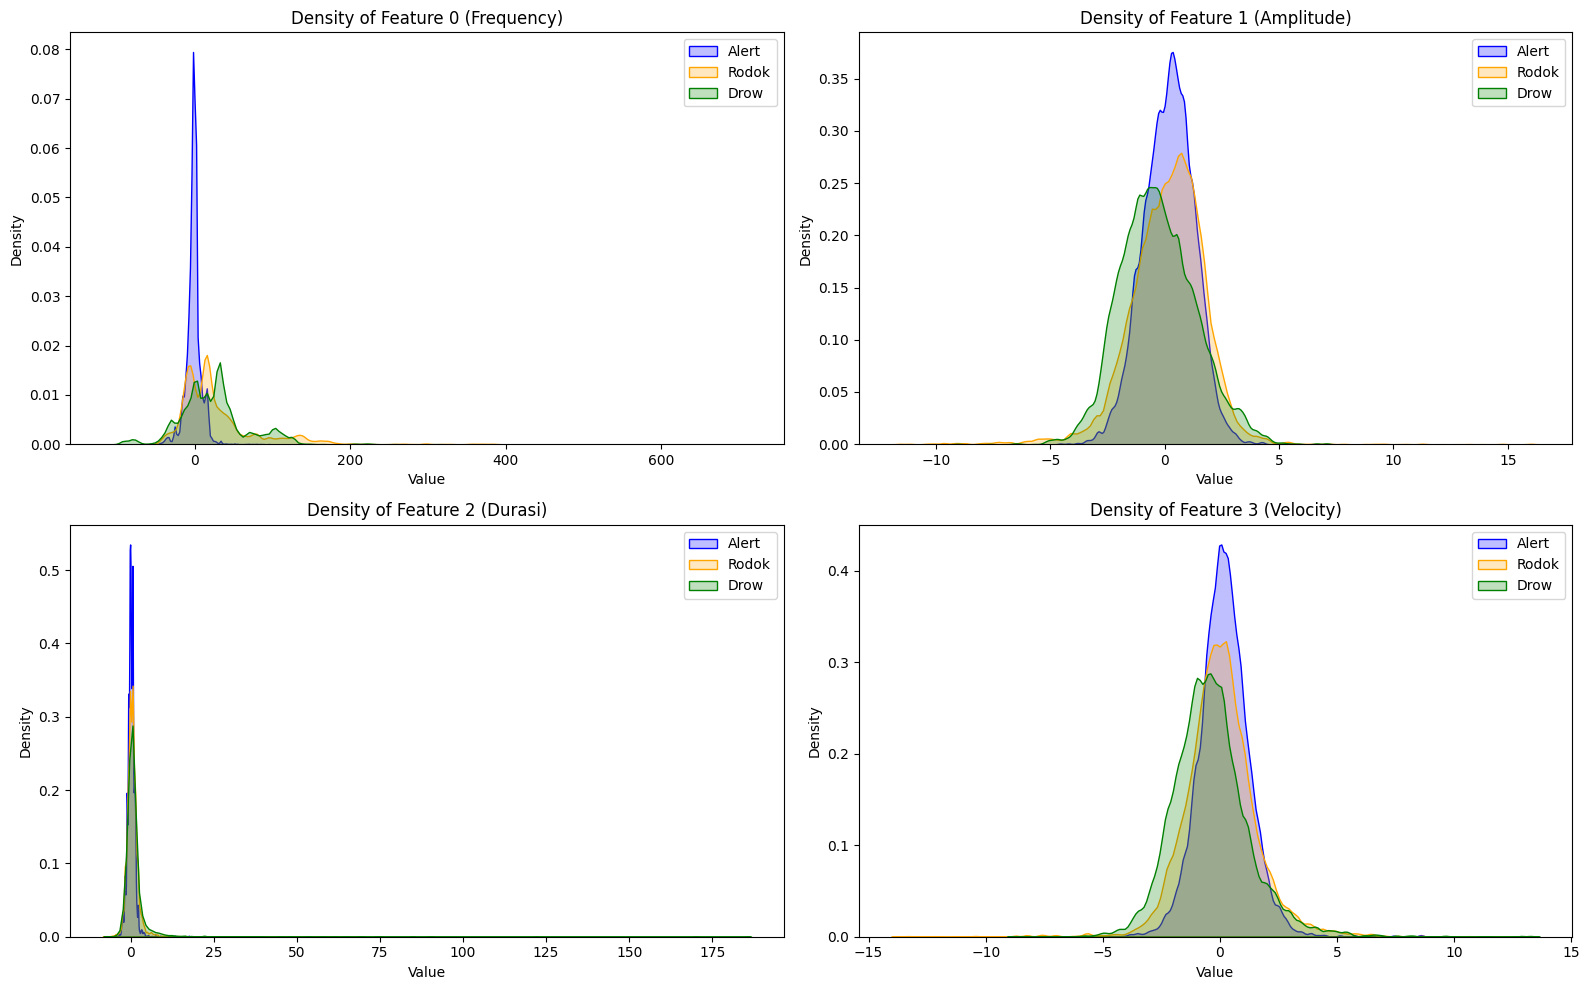

In [ ]:
feature_names = ['Frequency', 'Amplitude', 'Durasi', 'Velocity']
data_list = [
    alert_data,
    rodok_data,
    drow_data
]
labels = ['Alert', 'Rodok', 'Drow']
colors = ['blue', 'orange', 'green']

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

for i in range(4):
    row = i // 2
    col = i % 2
    for data, label, color in zip(data_list, labels, colors):
        sns.kdeplot(data[:, i], label=label, fill=True, ax=axs[row, col], color=color)
    axs[row, col].set_title(f'Density of Feature {i} ({feature_names[i]})')
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

Dari hasil plot density, bisa dilihat bahwa data cenderung runcing, hal ini disebabkan karena adanya outlier pada data sehingga perlu dilakukan penghapusan.

**Hapus Outier**

In [8]:

def detect_outliers_iqr(data, label):
    fitur_nama = ['Duration', 'Amplitude', 'EOV', 'Frequency']
    outlier_dict = {}

    print(f'\n=== Outlier Detection untuk kelas: {label} ===')
    for i, nama in enumerate(fitur_nama):
        kolom = data[:, i]
        Q1 = np.percentile(kolom, 25)
        Q3 = np.percentile(kolom, 75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_idx = np.where((kolom < lower) | (kolom > upper))[0]
        outlier_dict[nama] = outlier_idx
        print(f'Fitur: {nama}')
        print(f'  Jumlah outlier: {len(outlier_idx)}')
        print(f'  Indeks: {outlier_idx.tolist()}')

    return outlier_dict


def remove_outliers_iqr(data):
    mask = np.ones(data.shape[0], dtype=bool)
    for i in range(data.shape[1]):
        col = data[:, i]
        Q1 = np.percentile(col, 25)
        Q3 = np.percentile(col, 75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask &= (col >= lower) & (col <= upper)
    return data[mask]


alert_data_no_outliers = remove_outliers_iqr(alert_data)
rodok_data_no_outliers = remove_outliers_iqr(rodok_data)
drow_data_no_outliers = remove_outliers_iqr(drow_data)

**NOTE**

Penghapusan outlier dilakukan secara terpisah perkelas, data yang dianggap outlier adalah data yang melebihi batas bawah dan atas.

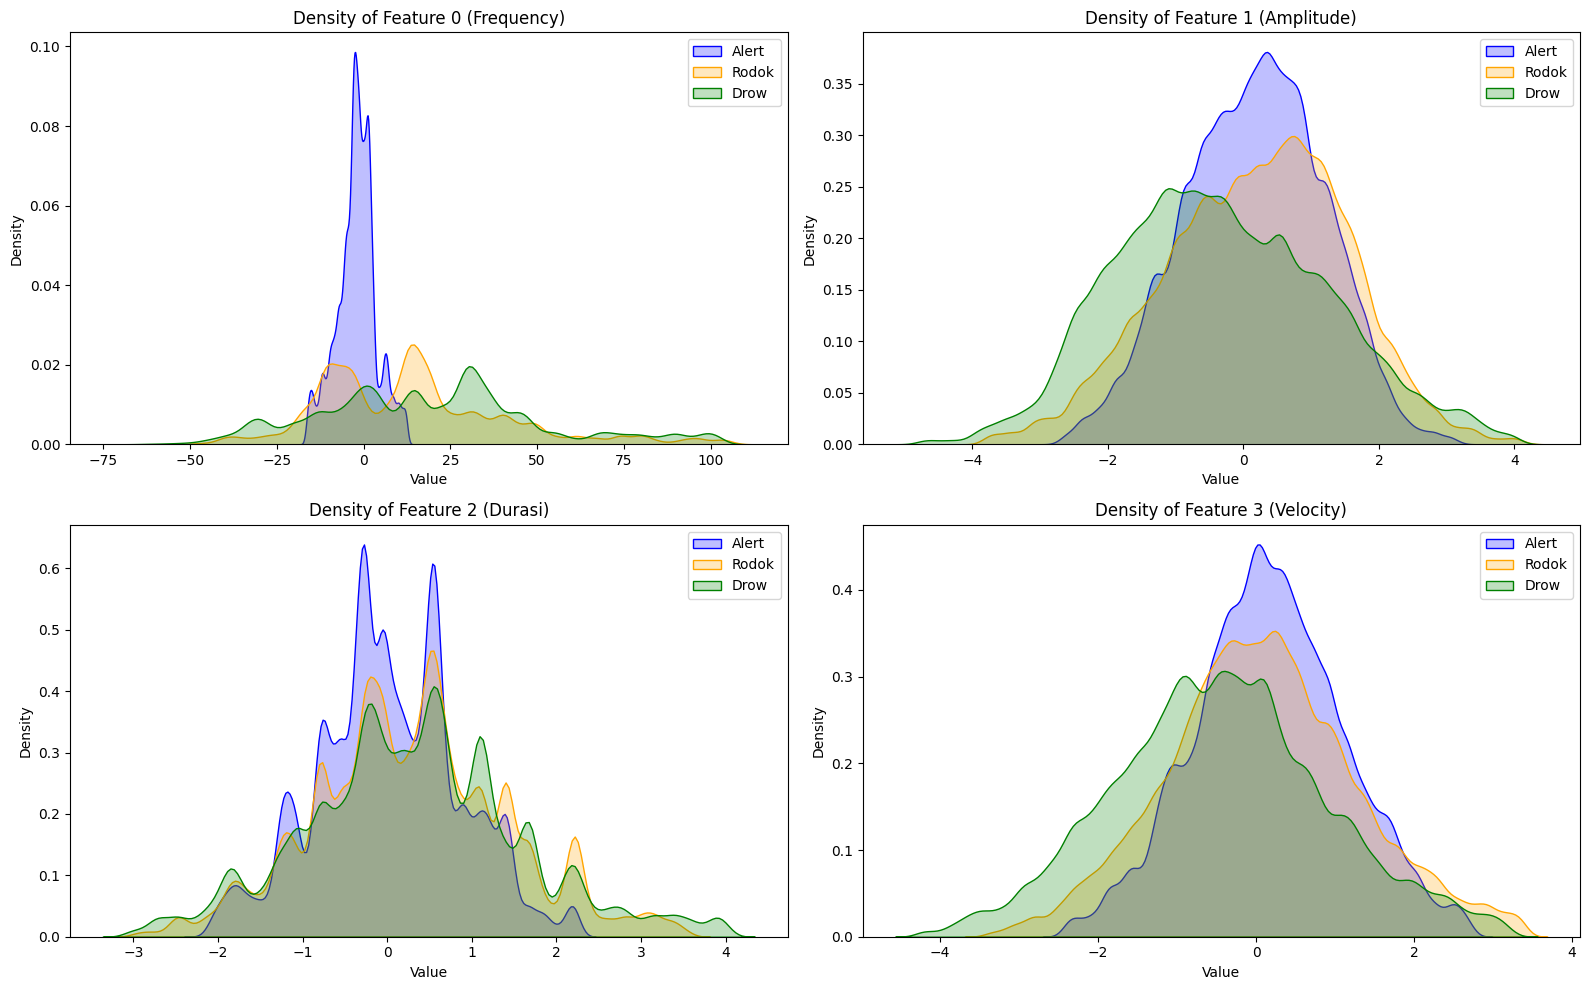

In [9]:
import seaborn as sns

feature_names = ['Frequency', 'Amplitude', 'Durasi', 'Velocity']
data_list = [
    alert_data_no_outliers,
    rodok_data_no_outliers,
    drow_data_no_outliers
]
labels = ['Alert', 'Rodok', 'Drow']
colors = ['blue', 'orange', 'green']

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

for i in range(4):
    row = i // 2
    col = i % 2
    for data, label, color in zip(data_list, labels, colors):
        sns.kdeplot(data[:, i], label=label, fill=True, ax=axs[row, col], color=color)
    axs[row, col].set_title(f'Density of Feature {i} ({feature_names[i]})')
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

In [10]:
X_final = np.vstack([
    alert_data_no_outliers,
    rodok_data_no_outliers,
    drow_data_no_outliers
])

y_final = np.concatenate([
    np.zeros(len(alert_data_no_outliers)),      # Label 0
    np.ones(len(rodok_data_no_outliers)),       # Label 1
    np.full(len(drow_data_no_outliers), 2)      # Label 2
])


In [13]:
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_final, y_final)


unique, counts = np.unique(y_under, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 129534, 1.0: 129534, 2.0: 129534}


In [14]:
np.save('dataset/UJI/Clean_Perblink/Feature_CLEAN.npy', X_under)
np.save('dataset/UJI/Clean_Perblink/Label_CLEAN.npy', y_under)

# Building Model

## Model GLVQ

In [30]:
class GLVQ:
    def __init__(self, learniing_rate):
        self.lr = learniing_rate
    
    def train(self, X, y, n_epoch):
        self.target = list(np.unique(y))
        
        W = []
        for i in self.target:
            for j in range(len(X)):
                if y[j] == i:
                    W.append(X[j])
                    break
        self.W = np.array(W)
        self.best_W = self.W.copy()
        self.best_fitness = None

        def sigmoid(x):
            return 1/(1 + np.exp(-x))
        
        def miu(d1, d2):
            return (d1 - d2)/(d1 + d2)

        for epoch in range(n_epoch):

            for dt in range(len(X)):
                dst = []
                vec_x = X[dt]
                y_act = y[dt]
                idk_prot = self.target.index(y_act)
                
                for k in range(self.W.shape[0]):
                    jarak = np.sqrt(np.sum((self.W[k] - vec_x)**2))
                    dst.append([k, jarak])
                
                dst.sort(key=lambda x: x[1])

                terdekat = dst[0]
                if terdekat[0] != idk_prot:
                    idk_d2 = terdekat[0]
                    d2 = terdekat[1]
                    for d in dst:
                        if d[0] == idk_prot:
                            d1 = d[1]
                else:
                    idk_d2 = dst[1][0]
                    d2 = dst[1][1]
                    d1 = terdekat[1]

                u = miu(d1, d2)
                a_tur = self.lr*(sigmoid(u)*(1 - sigmoid(u)))
                self.W[idk_prot] += (a_tur*(d2/((d1+d2)**2))) * (vec_x - self.W[idk_prot])
                self.W[idk_d2] -= (a_tur*(d1/((d2+d1)**2))) * (vec_x - self.W[idk_d2])

            acc, _ = self.predict(X, y)
            if self.best_fitness != None:
                if self.best_fitness[1] < acc:
                    self.best_fitness = (epoch+1, acc)
                    self.best_W = self.W.copy()
            else: 
                self.best_fitness = (epoch+1, acc)

            if epoch % 5 == 0:
                print(f'Epoch : {epoch+1} | Fitness : {acc}')
        print(f'Epoch : {epoch+1} | Fitness : {acc}')
        print(f'Best Epoch : {self.best_fitness[0]} | Best Fitness : {self.best_fitness[1]}')


    def predict(self, X, y = None):
        benar = 0
        all_pred = []

        if type(y) == np.ndarray:
            for i in range(len(X)):
                dst = []
                vec_x = X[i]
                for j in range(self.W.shape[0]):
                    jarak = np.sqrt(np.sum((self.W[j] - vec_x)**2))
                    dst.append([j, jarak])
                pred = min(dst, key=lambda x: x[1])
                dst.sort(key=lambda x: x[1])
                all_pred.append(self.target[pred[0]])
                if self.target[pred[0]] == y[i]:
                    benar += 1
            akurasi = benar/len(y)
            return akurasi, all_pred
        else:
            for i in range(len(X)):
                dst = []
                vec_x = X[i]
                for j in range(self.W.shape[0]):
                    jarak = np.sqrt(np.sum((self.W[j] - vec_x)**2))
                    dst.append([j, jarak])
                pred = min(dst, key=lambda x: x[1])
                dst.sort(key=lambda x: x[1])
                all_pred.append(self.target[pred[0]])
            return all_pred


## Model MLP-Backpropagation
1 Hidden Layer + Aktivasi Sigmoid

In [3]:
class ML_Backpropagation:

    def __init__(self, learning_rate = 0.1, n_hidden = 5):
        self.lr = learning_rate
        self.n_hidden = n_hidden
    
    def __aktivasi(self, val):
        return 1/(1+np.exp(-val))
    
    def __turunan(self, val):
        fx = self.__aktivasi(val)
        return fx * (1 - fx)

    def __maju(self, X, w, v):
        z_in = np.dot(X, w)
        z = np.array([1] + [self.__aktivasi(z_ini) for z_ini in z_in])
        y_in = np.dot(z, v)
        y = np.array([self.__aktivasi(y_ini) for y_ini in y_in])
        return y, y_in, z, z_in
    
    def __mundur(self, y_act, y_pred, y_in, z, z_in, w, v):
        t = [0 for k in range(len(y_pred))]
        if len(y_pred) > 1:
            t[y_act] = 1
        else:
            t = [y_act]

        d_output = []
        for i in range(len(y_pred)):
            pred = y_pred[i]
            pred_in = y_in[i]
            d = (t[i] - pred) * (self.__turunan(pred_in))
            d_output.append(d)
        d_output = np.array(d_output)
        d_hidden = []
        for j in range(len(z_in)):
            d_inj = np.dot(d_output, v[j, :].T)
            z_pure = z_in[j]
            d = d_inj*(self.__turunan(z_pure))
            d_hidden.append(d)
        return np.array(d_output), np.array(d_hidden)
    
    def __update(self, X, z, do, dh, w, v, lr):
        delta_w = np.array([X * dh[i] * lr for i in range(len(dh))]).T
        w += delta_w

        delta_v = np.array([z * do[j] * lr for j in range(len(do))]).T
        v += delta_v
        return w, v
    
    def train(self, X, y, epoch = 1, jenis = 'train awal'):

        arr_b = np.array([1 for i in range(len(X))])
        X = np.column_stack((arr_b, X))
        if len(y.shape) > 1:
            y = y.reshape((y.shape[0]))
            
        if jenis == 'train awal':
            self.n_output = len(np.unique(y))
            if self.n_output < 3:
                self.n_output = 1

            self.w = np.random.uniform(0, 0.1, (X.shape[1], self.n_hidden))
            self.v = np.random.uniform(0, 0.1, (self.n_hidden+1, self.n_output))

            self.best_fitness = None
            self.best_w = self.w.copy()
            self.best_v = self.v.copy()


        toleransi_ep = 50
        stuck = 0


        for ep in range(epoch):
            for i in range(X.shape[0]):
                Xi = X[i]
                y_act = y[i]
                y_pred, y_in, z, z_in = self.__maju(Xi, self.w, self.v)
                do, dh = self.__mundur(y_act, y_pred, y_in, z, z_in, self.w, self.v)
                self.w, self.v = self.__update(Xi, z, do, dh, self.w, self.v, self.lr)

            acc = self.evaluation(X, y)
            # print(self.best_fitness)
            if self.best_fitness != None:
                if self.best_fitness[1] < acc:
                    stuck = 0
                    self.best_fitness = (ep+1, acc)
                    self.best_w = self.w.copy()
                    self.best_v = self.v.copy()
                elif stuck == toleransi_ep:
                    print(f"Training dihentikan")
                    print(f"Epoch {ep+1}: Fitness = {acc:.4f}")
                    break
                else:
                    stuck += 1
            else:
                self.best_fitness = (ep+1, acc)

            if ep % 20 == 0:
                print(f"Epoch {ep+1}: Fitness = {acc:.4f}")

        print(f"Best Epoch {self.best_fitness[0]}: Fitness = {self.best_fitness[1]:.4f}")


    def predict(self, X):
        prediksi = []
        if sum(X[:, 0]) != len(X):
            arr_b = np.array([1 for i in range(len(X))])
            X = np.column_stack((arr_b, X))
            
        for i in range(X.shape[0]):
            y_pred, yin, z, zin = self.__maju(X[i], self.w, self.v)
            prediksi.append(np.argmax(y_pred))
        return np.array(prediksi)
    
    def evaluation(self, X, y):
        prediksi = self.predict(X)
        benar = 0
        for i in range(len(y)):
            if prediksi[i] == y[i]:
                benar += 1
        
        return benar/len(y)

## Model SVM (SMO + OvO)

In [124]:
class SVM:

    def __init__(self, C=1, eps=0.001):
        self.b = 0
        self.C = C
        self.eps = eps

    def kernel(self, x1, x2):
        return (np.dot(x1, x2.T) + 1)**2


    def objective_function(self, a1, a2, i, j, s, L, H, y1, y2, E1, E2, b):
        f1 = y1*(E1 + b) - (a1* self.mat_kernel[i, i]) - (s*a2*self.mat_kernel[i, j])
        f2 = y2*(E2 + b) - (s*a1* self.mat_kernel[i, j]) - (a2*self.mat_kernel[j, j])
        L1 = a1 + s*(a2 - L)
        H1 = a1 + s*(a2 - H)
        Lobj = (L1*f1) + (L*f2) + (0.5 * (L1**2) * self.mat_kernel[i, i]) + (0.5 * (L**2) * self.mat_kernel[j, j] + s*L*L1*self.mat_kernel[i, j])
        Hobj = (H1*f1) + (H*f2) + (0.5 * (H1**2) * self.mat_kernel[i, i]) + (0.5 * (H**2) * self.mat_kernel[j, j] + s*H*H1*self.mat_kernel[i, j])
        return Lobj, Hobj

    def ui(self, i):
        idk_nonzero = np.nonzero(self.a)
        if type(i) == int or type(i) == np.int64:
            return np.sum((self.a[idk_nonzero] * self.y[idk_nonzero] * self.mat_kernel[i, idk_nonzero])) - self.b
        elif type(i) == np.ndarray:
            return np.sum((self.a[idk_nonzero] * self.y[idk_nonzero] * self.kernel(i, self.X[idk_nonzero]))) - self.b
        else:
            print(type(i))
            raise ValueError("Parameter i harus berupa integer atau array numpy")

    def optimasi_a(self, i, j, y2, a2, x2, E2):
        if i == j:
            return 0
        a1 = self.a[i]
        y1 = self.y[i]
        x1 = self.X[i]

        if self.E_aktif[i] > 0:
            E1 = self.E[i]
        else:
            E1 = self.ui(i) - y1
            # self.E_aktif[i] = 1

        s = y1 * y2
        if s == -1: # Pers. 13 Hal 7
            L = max(0, a2 - a1)
            H = min(self.C, self.C + a2 - a1)
        else: # Pers. 14
            L = max(0, a2 + a1 - self.C)
            H = min(self.C, a2 + a1)
        if L == H:
            return 0
        k11 = self.mat_kernel[i, i]
        k12 = self.mat_kernel[i, j]
        k22 = self.mat_kernel[j, j]
        eta = k11 + k22 - (2 * k12)  # Pers. 15
        if eta > 0:
            a2_draft = a2 + ((y2*(E1 - E2))/eta) # Pers. 16
            if a2_draft < L: # Pers. 17
                a2_draft = L
            elif a2_draft > H:
                a2_draft = H
        else: # Pers. 19 hal 8
            Lobj, Hobj = self.objective_function(a1=a1, a2=L, i=i, j=j, s=s, L=L, H=H, y1=y1, y2=y2, E1=E1, E2=E2, b=self.b)
            if Lobj < (Hobj - self.eps):
                a2_draft = L
            elif Lobj > (Hobj + self.eps):
                a2_draft = H
            else:
                a2_draft = a2

        if (np.abs(a2_draft - a2) < (self.eps*(a2_draft+a2+self.eps))):
            return 0
        # print((L, H))
        a1_draft = a1+(s*(a2-a2_draft)) # pers. 18 hal 7

        b1 = E1 + (y1*(a1_draft - a1)* k11) + (y2*(a2_draft - a2)* k12) + self.b # pers. 20 hal 9
        b2 = E2 + (y1*(a1_draft - a1)* k12) + (y2*(a2_draft - a2)* k22) + self.b # pers. 21

        if (0 < a1_draft < self.C):
            self.b = b1
        elif (0 < a2_draft < self.C):
            self.b = b2
        else:
            self.b = (b1 + b2)/2
        # print(f'B baru = {self.b}')
        
        # gapenting
        # self.w = self.w + y1*(a1_draft - a1)*x1 + y2*(a2_draft - a2)*x2 # pers. 22

        self.a[i] = a1_draft
        self.a[j] = a2_draft
        # print(i)
        self.E[i] = self.ui(i) - y1
        self.E_aktif[i] = 1
        self.E[j] = self.ui(j) - y2
        self.E_aktif[j] = 1
        # print('|', end='')
        return 1

    def cari_pasangan(self, j):
        y2 = self.y[j]
        a2 = self.a[j]
        x2 = self.X[j]
        if self.E_aktif[j] > 0:
            E2 = self.E[j]
        else:
            E2 = self.ui(j) - y2
            # self.E_aktif[j] = 1
        # print(self.ui(j))
        r2 = E2*y2

        if (((r2 < -self.eps) and (a2 < self.C))|((r2 > self.eps) and (a2 > 0))):
            non_bond = 0
            for an in self.a:
                if 0 < an < self.C:
                    non_bond += 1
            if non_bond > 1:
                i = np.argmax(np.abs(self.E - E2))
                if self.optimasi_a(i, j, y2, a2, x2, E2):
                    return 1
                
            for k in range(self.a.shape[0]):
                if 0 < self.a[k] < self.C:
                    i = k
                    if self.optimasi_a(i, j, y2, a2, x2, E2):
                        return 1
                    
            for k in range(self.a.shape[0]):
                i = k
                if self.optimasi_a(i, j, y2, a2, x2, E2):
                    return 1
        
        return 0


    def train(self, X, target):
        y = target.copy()
        kelas = set(np.unique(y))
        if len(kelas) != 2:
            raise ValueError("Jumlah class harus 2")
        elif kelas != {-1, 1}:
            kelas_act = list(np.unique(y))
            for i in range(len(y)):
                gol = y[i]
                y[i] = -1 if kelas_act.index(gol) == 0 else 1
        else:
            kelas_act = [-1, 1]
        self.dct_transform = {
            -1: kelas_act[0],
            1: kelas_act[1]
        }

        self.X = X
        self.y = y.reshape((y.shape[0]))
        print(self.y.shape)
        self.mat_kernel = self.kernel(self.X, self.X)
        print(self.mat_kernel.shape)
        self.a = np.zeros((self.X.shape[0]))
        self.E = np.zeros((self.X.shape[0]))
        self.E_aktif = np.zeros((self.X.shape[0]))
        # self.w = np.zeros((self.X.shape[1]))

        num_changed = 0
        is_all = 1
        tot_iter = 0
        while ((num_changed > 0) or (is_all)) and tot_iter < 10000:
            tot_iter += 1
            print(f'Iterasi ke-{tot_iter}')
            num_changed = 0
            if is_all:
                for j in range(self.a.shape[0]):
                    num_changed += self.cari_pasangan(j)
            else:
                for j in range(self.a.shape[0]):
                    if 0 < self.a[j] < self.C:
                        num_changed += self.cari_pasangan(j)

            print(f'\n=========={num_changed}==========\n')
            if is_all == 1:
                is_all = 0
            elif num_changed == 0:
                is_all = 1

        hasil = self.predict(self.X)
        salah = 0
        for i in range(hasil.shape[0]):
            if hasil[i] != target[i]:
                salah += 1
        del self.mat_kernel
        self.fitness = 1 - (salah/(hasil.shape[0]))

        
    def predict(self, X: np.array):
        bentuk = X.shape
        if len(bentuk) == 1:
            pred_in = np.sign(self.ui(X))
            if pred_in == 0:
                pred_in = 1
            hasil = [self.dct_transform[pred_in]]
        elif len(bentuk) == 2:
            hasil = []
            for i in range(X.shape[0]):
                pred_in = np.sign(self.ui(X[i]))
                if pred_in == 0:
                    pred_in = 1
                hasil.append(self.dct_transform[pred_in])
        else: 
            raise ValueError("Bentuk X harus array 1 atau 2 D")
        return np.array(hasil)


**Multiclass One VS One**

In [125]:
class SVM_Multiclass:

    def __init__(self, C=1, eps=0.001):
        self.b = 0
        self.C = C
        self.eps = eps

    def train(self, fitur, target):
        kelas = np.unique(target)
        if len(kelas) < 3:
            raise ValueError("Kelas harus 2")
        self.kelas = kelas
        self.pasangan = []
        for i in range(len(self.kelas)):
            for j in range(i+1, len(self.kelas)):
                self.pasangan.append([self.kelas[i], self.kelas[j]])
        
        self.fitur_pasangan = []
        self.label_pasangan = []
        self.X = fitur
        self.y = target
        for pas in self.pasangan:
            kumdat = []
            kumy = []
            for i in range(len(self.X)):
                if self.y[i] in pas:
                    kumdat.append(self.X[i])
                    kumy.append(self.y[i])
            self.fitur_pasangan.append(kumdat)
            self.label_pasangan.append(kumy)
        
        self.models = []
        for i in range(len(self.pasangan)):
            print(f'\nTrain Model {kelas[i]}')
            model = SVM(C=self.C, eps=self.eps)
            X_tr = np.array(self.fitur_pasangan[i])
            y_tr = np.array(self.label_pasangan[i])
            model.train(X_tr, y_tr)
            self.models.append(model)

        fit = self.evaluation(self.X, self.y)
        print(f'Fitness : {fit:.4f}')

    def predict(self, fitur):
        X = fitur
        bentuk = X.shape
        if len(bentuk) == 1:
            return
        
        val = []
        for idk in range(len(X)):
            prediksi = np.unique(np.array([self.models[m].predict(X[idk]) for m in range(len(self.models))]), return_counts=True)
            # print(prediksi)
            rill_pred = prediksi[0][np.argmax(prediksi[1])]
            # print(rill_pred)
            val.append(rill_pred)
        val

        return np.array(val)


    def evaluation(self, fitur, target):
        prediksi = self.predict(fitur)
        benar = 0
        for i in range(len(target)):
            if prediksi[i] == target[i]:
                benar += 1
        
        return benar/len(target)

# Training Model 3 Scenario

## SC 1 (Base Model)

### Load Data

In [26]:
X_base = np.load('dataset/UJI/Base Model/Feature_FULL.npy')
y_base = np.load('dataset/UJI/Base Model/Label_FULL.npy')
print(X_base.shape, y_base.shape)

y_base = y_base.astype(int)
print(np.unique(y_base))

(27635, 120) (27635, 1)
[0 1 2]


### GLVQ

In [32]:
base_glvq = GLVQ(learniing_rate=0.1)
base_glvq.train(X_base, y_base, 30)

Epoch : 1 | Fitness : 0.4456305409806405
Epoch : 6 | Fitness : 0.5054459924009408
Epoch : 11 | Fitness : 0.5205355527410892
Epoch : 16 | Fitness : 0.5300524696942284
Epoch : 21 | Fitness : 0.5349013931608467
Epoch : 26 | Fitness : 0.5318255834991858
Epoch : 30 | Fitness : 0.5193776008684639
Best Epoch : 24 | Best Fitness : 0.5360955310294916


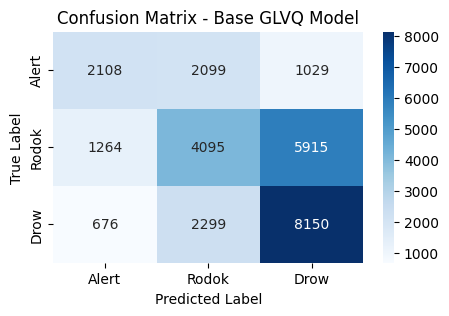

In [36]:
y_pred_base_glvq = base_glvq.predict(X_base)
cm_base_glvq = confusion_matrix(y_base, y_pred_base_glvq)
plt.figure(figsize=(5, 3))
sns.heatmap(cm_base_glvq, annot=True, fmt='d', cmap='Blues', xticklabels=['Alert', 'Rodok', 'Drow'], yticklabels=['Alert', 'Rodok', 'Drow'])
plt.title('Confusion Matrix - Base GLVQ Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### MLP-Backpro

In [38]:
base_bp_10 = ML_Backpropagation(learning_rate=0.01, n_hidden=10)
base_bp_10.train(X_base, y_base, epoch=150)

Epoch 1: Fitness = 0.4304


C:\Users\ADVAN\AppData\Local\Temp\ipykernel_5988\2694102478.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-val))


Epoch 21: Fitness = 0.5309
Epoch 41: Fitness = 0.6224
Epoch 61: Fitness = 0.6256
Epoch 81: Fitness = 0.5873
Training dihentikan
Epoch 82: Fitness = 0.5711
Best Epoch 31: Fitness = 0.6346


C:\Users\ADVAN\AppData\Local\Temp\ipykernel_5988\2694102478.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-val))


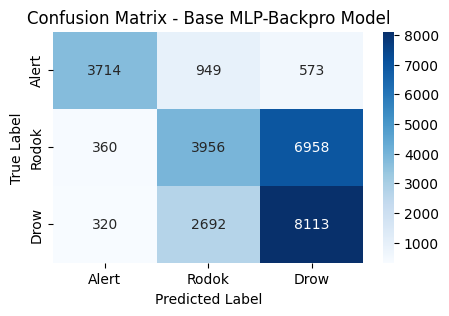

In [39]:
y_pred_base_bp_10 = base_bp_10.predict(X_base)
cm_base_bp_10 = confusion_matrix(y_base, y_pred_base_bp_10)
plt.figure(figsize=(5, 3))
sns.heatmap(cm_base_bp_10, annot=True, fmt='d', cmap='Blues', xticklabels=['Alert', 'Rodok', 'Drow'], yticklabels=['Alert', 'Rodok', 'Drow'])
plt.title('Confusion Matrix - Base MLP-Backpro Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVM

In [126]:
base_svm = SVM_Multiclass(C=1, eps=0.001)
base_svm.train(X_base, y_base)


Train Model 0
(16510,)
(16510, 16510)
Iterasi ke-1

==========4842==========

Iterasi ke-2

==========4==========

Iterasi ke-3

==========1==========

Iterasi ke-4

==========1==========

Iterasi ke-5

==========1==========

Iterasi ke-6

==========2==========

Iterasi ke-7

==========0==========

Iterasi ke-8

==========1749==========

Iterasi ke-9

==========23==========

Iterasi ke-10

==========16==========

Iterasi ke-11

==========12==========

Iterasi ke-12

==========9==========

Iterasi ke-13

==========8==========

Iterasi ke-14

==========1==========

Iterasi ke-15

==========1==========

Iterasi ke-16

==========2==========

Iterasi ke-17

==========0==========

Iterasi ke-18

==========681==========

Iterasi ke-19

==========24==========

Iterasi ke-20

==========12==========

Iterasi ke-21

==========5==========

Iterasi ke-22

==========1==========

Iterasi ke-23

==========1==========

Iterasi ke-24

==========0==========

Iterasi ke-25

==========342==========

Itera

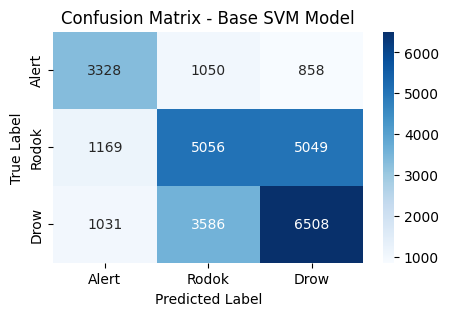

In [128]:
y_pred_base_svm = base_svm.predict(X_base)
cm_base_svm = confusion_matrix(y_base, y_pred_base_svm)
plt.figure(figsize=(5, 3))
sns.heatmap(cm_base_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Alert', 'Rodok', 'Drow'], yticklabels=['Alert', 'Rodok', 'Drow'])
plt.title('Confusion Matrix - Base SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SC 2 (Mean Model)

### Load Data

In [50]:
X_mean = np.load('dataset/UJI/Mean/Feature_MEAN_Blink.npy')
y_mean = np.load('dataset/UJI/Mean/Label_MEAN_Blink.npy')
print(X_mean.shape, y_mean.shape)

y_mean = y_mean.astype(int)
print(np.unique(y_mean))

(27635, 4) (27635, 1)
[0 1 2]


### GLVQ

In [51]:
mean_glvq = GLVQ(learniing_rate=0.1)
mean_glvq.train(X_mean, y_mean, 30)

Epoch : 1 | Fitness : 0.511344309752126
Epoch : 6 | Fitness : 0.5101501718834811
Epoch : 11 | Fitness : 0.4886195042518545
Epoch : 16 | Fitness : 0.4685362764610096
Epoch : 21 | Fitness : 0.45768047765514747
Epoch : 26 | Fitness : 0.45630540980640494
Epoch : 30 | Fitness : 0.4538809480730957
Best Epoch : 3 | Best Fitness : 0.5234666184186719


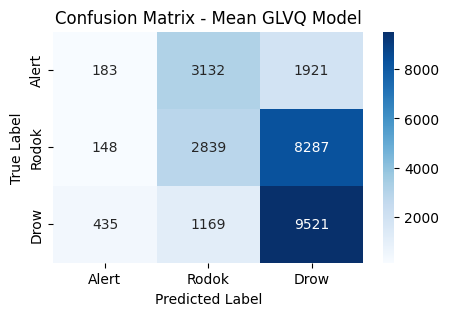

In [52]:
y_pred_mean_glvq = mean_glvq.predict(X_mean)
cm_mean_glvq = confusion_matrix(y_mean, y_pred_mean_glvq)
plt.figure(figsize=(5, 3))
sns.heatmap(cm_mean_glvq, annot=True, fmt='d', cmap='Blues', xticklabels=['Alert', 'Rodok', 'Drow'], yticklabels=['Alert', 'Rodok', 'Drow'])
plt.title('Confusion Matrix - Mean GLVQ Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### MLP-Backpro

In [53]:
mean_bp_10 = ML_Backpropagation(learning_rate=0.01, n_hidden=10)
mean_bp_10.train(X_mean, y_mean, epoch=150)

Epoch 1: Fitness = 0.4550
Epoch 21: Fitness = 0.6038
Epoch 41: Fitness = 0.6112
Epoch 61: Fitness = 0.6306
Epoch 81: Fitness = 0.6571
Epoch 101: Fitness = 0.6270
Epoch 121: Fitness = 0.6282


C:\Users\ADVAN\AppData\Local\Temp\ipykernel_5988\2694102478.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-val))


Training dihentikan
Epoch 133: Fitness = 0.6231
Best Epoch 82: Fitness = 0.6581


C:\Users\ADVAN\AppData\Local\Temp\ipykernel_5988\2694102478.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-val))


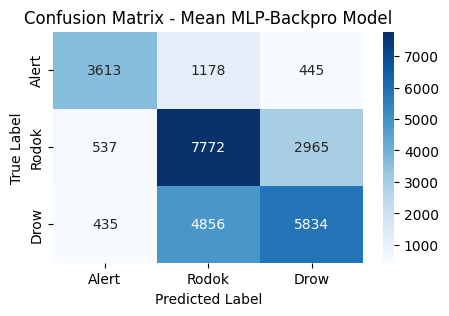

In [56]:
y_pred_mean_bp_10 = mean_bp_10.predict(X_mean)
cm_mean_bp_10 = confusion_matrix(y_mean, y_pred_mean_bp_10)
plt.figure(figsize=(5, 3))
sns.heatmap(cm_mean_bp_10, annot=True, fmt='d', cmap='Blues', xticklabels=['Alert', 'Rodok', 'Drow'], yticklabels=['Alert', 'Rodok', 'Drow'])
plt.title('Confusion Matrix - Mean MLP-Backpro Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVM

In [ ]:
mean_svm = SVM_Multiclass(C=1, eps=0.001)
mean_svm.train(X_mean, y_mean)

In [ ]:
y_pred_mean_svm = mean_svm.predict(X_mean)
cm_mean_svm = confusion_matrix(y_mean, y_pred_mean_svm)
plt.figure(figsize=(5, 3))
sns.heatmap(cm_mean_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Alert', 'Rodok', 'Drow'], yticklabels=['Alert', 'Rodok', 'Drow'])
plt.title('Confusion Matrix - Mean SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SC 3 : (Clean PerBlink Model)

### Load Data

In [127]:
X_clean = np.load('dataset/UJI/Clean_Perblink/Feature_CLEAN.npy')
y_clean = np.load('dataset/UJI/Clean_Perblink/Label_CLEAN.npy')
print(X_clean.shape, y_clean.shape)

y_clean = y_clean.astype(int)
print(np.unique(y_clean))

(388602, 4) (388602,)
[0 1 2]


### GLVQ

In [129]:
clean_glvq = GLVQ(learniing_rate=0.1)
clean_glvq.train(X_clean, y_clean, 30)

Epoch : 1 | Fitness : 0.3333333333333333
Epoch : 6 | Fitness : 0.3333333333333333
Epoch : 11 | Fitness : 0.3333333333333333
Epoch : 16 | Fitness : 0.3333333333333333
Epoch : 21 | Fitness : 0.3333333333333333
Epoch : 26 | Fitness : 0.3333333333333333
Epoch : 30 | Fitness : 0.3333333333333333
Best Epoch : 1 | Best Fitness : 0.3333333333333333


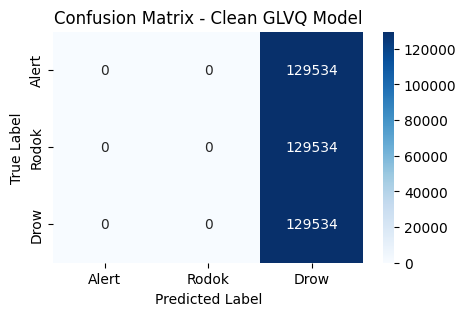

In [130]:
y_pred_clean_glvq = clean_glvq.predict(X_clean)
cm_clean_glvq = confusion_matrix(y_clean, y_pred_clean_glvq)
plt.figure(figsize=(5, 3))
sns.heatmap(cm_clean_glvq, annot=True, fmt='d', cmap='Blues', xticklabels=['Alert', 'Rodok', 'Drow'], yticklabels=['Alert', 'Rodok', 'Drow'])
plt.title('Confusion Matrix - Clean GLVQ Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### MLP-Backpro

In [ ]:
clean_bp_10 = ML_Backpropagation(learning_rate=0.01, n_hidden=10)
clean_bp_10.train(X_clean, y_clean, epoch=150)

**training dihentikan karena proses terlalu lama**

### SVM

In [ ]:
clean_svm = SVM_Multiclass(C=1, eps=0.001)
clean_svm.train(X_clean, y_clean)

**training dihentikan karena proses terlalu lama**

# Fokus MLP-BP Mean (Best Model)

In [132]:
mean_bp_20 = ML_Backpropagation(learning_rate=0.001, n_hidden=20)
mean_bp_20.train(X_mean, y_mean, epoch=500)

Epoch 1: Fitness = 0.4203
Epoch 21: Fitness = 0.4997
Epoch 41: Fitness = 0.6072
Epoch 61: Fitness = 0.6224
Epoch 81: Fitness = 0.6478
Epoch 101: Fitness = 0.6578
Epoch 121: Fitness = 0.6735
Epoch 141: Fitness = 0.6884
Epoch 161: Fitness = 0.6953
Epoch 181: Fitness = 0.7016
Epoch 201: Fitness = 0.7086
Epoch 221: Fitness = 0.7114
Epoch 241: Fitness = 0.7107
Epoch 261: Fitness = 0.7103
Epoch 281: Fitness = 0.7083
Training dihentikan
Epoch 282: Fitness = 0.7085
Best Epoch 231: Fitness = 0.7120


In [134]:
mean_bp_20.train(X_mean, y_mean, epoch=500, jenis='train ulang')

Epoch 1: Fitness = 0.6823
Epoch 21: Fitness = 0.7006
Epoch 41: Fitness = 0.7121
Epoch 61: Fitness = 0.7153
Epoch 81: Fitness = 0.7167
Epoch 101: Fitness = 0.7167
Epoch 121: Fitness = 0.7170
Epoch 141: Fitness = 0.7177
Training dihentikan
Epoch 147: Fitness = 0.7188
Best Epoch 96: Fitness = 0.7234


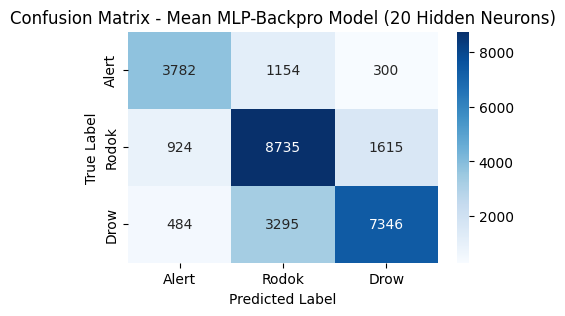

In [135]:
y_pred_mean_bp_20 = mean_bp_20.predict(X_mean)
cm_mean_bp_20 = confusion_matrix(y_mean, y_pred_mean_bp_20)
plt.figure(figsize=(5, 3))
sns.heatmap(cm_mean_bp_20, annot=True, fmt='d', cmap='Blues', xticklabels=['Alert', 'Rodok', 'Drow'], yticklabels=['Alert', 'Rodok', 'Drow'])
plt.title('Confusion Matrix - Mean MLP-Backpro Model (20 Hidden Neurons)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [138]:
fl = 'model/Mean_BP_20.pickle'
with open(fl, 'wb') as f:
    pickle.dump(mean_bp_20, f)
f.close()

# Rancangan Ekstraksi Kedipan

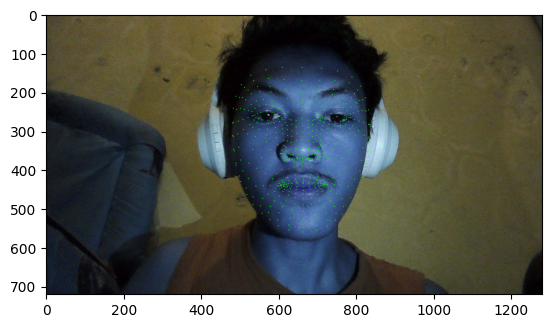

In [11]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

frame = cv2.imread('dataset/Sampel_img/Normal.jpg')

rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
result = face_mesh.process(rgb_frame)

if result.multi_face_landmarks:
    for face_landmarks in result.multi_face_landmarks:
        for lm in face_landmarks.landmark:
            h, w, _ = frame.shape
            x, y = int(lm.x * w), int(lm.y * h)
            cv2.circle(frame, (x, y), 1, (0, 255, 0), -1)

plt.imshow(frame)

**Sumber Mapping FaceLandmmarks** </br>
https://github.com/tensorflow/tfjs-models/blob/master/face-landmarks-detection/mesh_map.jpg

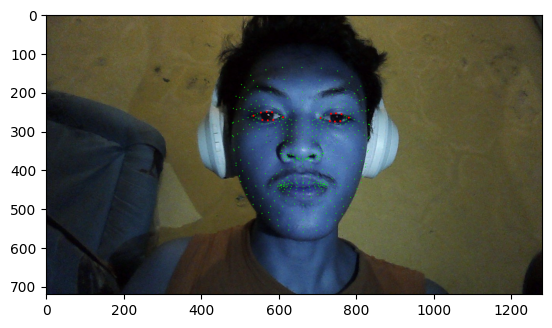

In [12]:
titik_landmark = result.multi_face_landmarks

koor_mata_kanan = [33, 160, 159, 158, 133, 153, 145, 144]
koor_mata_kiri = [362, 385, 386, 387, 263, 373, 374, 380]
for i in koor_mata_kanan:
    coor_x = int(titik_landmark[0].landmark[i].x * w)
    coor_y = int(titik_landmark[0].landmark[i].y * h)
    cv2.circle(img=frame, center=(coor_x, coor_y), radius=1, color=(255, 0, 0), thickness=2)

for j in koor_mata_kiri:
    coor_x = int(titik_landmark[0].landmark[j].x * w)
    coor_y = int(titik_landmark[0].landmark[j].y * h)
    cv2.circle(img=frame, center=(coor_x, coor_y), radius=1, color=(255, 0, 0), thickness=2)

plt.imshow(frame)

Dari 8 titik pada masing-masing mata tersebut dilakukan perhitungan jarak dengan satuan pixel lalu dihitung EAR (Eye Aspect Ratio)-nya.

In [ ]:
def jarak(koor1, koor2):
    d = np.sqrt(np.sum((np.array(koor1) - np.array(koor2))**2))
    return d

def mata(sebelah, h, w, titik_landmark):
    if sebelah == 'kanan':
        titik_mata = [33, 160, 159, 158, 133, 153, 145, 144]
    elif sebelah == 'kiri':
        titik_mata = [362, 385, 386, 387, 263, 373, 374, 380]
    else: return None

    komp = []
    for ttk in titik_mata:
        komp.append([(titik_landmark[0].landmark[ttk].x * w), (titik_landmark[0].landmark[ttk].y * h)])
    
    return komp

def EAR(komp):

    A = jarak(komp[1], komp[7])
    B = jarak(komp[2], komp[6])
    C = jarak(komp[3], komp[5])
    D = jarak(komp[0], komp[4])
    
    ear = (A + B + C)/(3*D)
    return ear



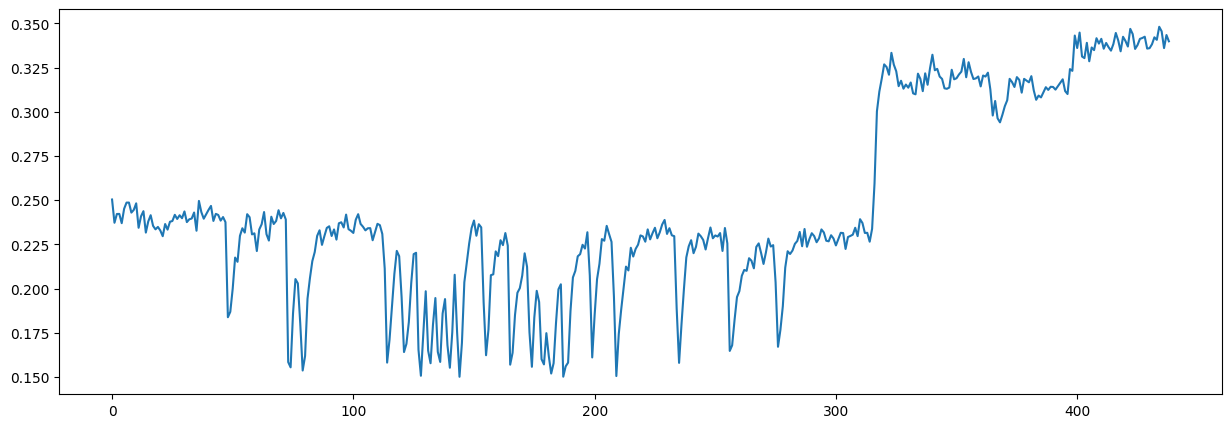

In [ ]:
cap = cv2.VideoCapture('dataset/Sampel_img/fast blink.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
lst_ear_kanan = []
lst_ear_kiri = []
lst_ear = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    h, w, _ = frame.shape
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    titik_landmark = results.multi_face_landmarks
    ear_kanan = EAR(mata('kanan', h, w, titik_landmark))
    ear_kiri = EAR(mata('kiri', h, w, titik_landmark))
    lst_ear_kanan.append(ear_kanan)
    lst_ear_kiri.append(ear_kiri)
    lst_ear.append(np.mean([ear_kanan, ear_kiri]))

kn = np.array(lst_ear_kanan)
kr = np.array(lst_ear_kiri)
ear_maen = np.array(lst_ear)

plt.figure(figsize=(12, 6))
plt.plot(ear_maen, color='blue')
plt.show()

Kami melihat bahwa jika seseorang berkedip maka earnya akan drop dan naik dengan cepat. Menurut referensi pemotongan atau windowing yang bagus adalah 13 frame (13 data EAR). Sehingga kami merancang proses pendeteksian kedipan dengan cara:

1. Menangkap 13 EAR
2. Cek apakah pada index ke 7 merupakan yang terkecil
3. Cek jika terkecil apakah dibawah 0.2 (untuk menangkap pola EAR drop) dan apakah EAR selanjutnya itu naik diatas 0.2.
4. jika semua terpenuhi maka kedipan terdeteksi, lalu dihitung 4 fitur utamanya.

In [ ]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

cap = cv2.VideoCapture('dataset/Sampel_img/fast blink.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
lst_ear = []
blink = 0
arr = np.zeros([13])
pnh = 0
fitur = []
i = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    i += 1
    h, w, _ = frame.shape
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if not results.multi_face_landmarks:
        break

    titik_landmark = results.multi_face_landmarks
    ear_kanan = EAR(mata('kanan', h, w, titik_landmark))
    ear_kiri = EAR(mata('kiri', h, w, titik_landmark))
    ear = np.mean([ear_kanan, ear_kiri])

    pnh += 1
    arr = shift(arr, -1, cval=ear)
    peak = arr[4:9]
    if pnh > 12 and np.argmin(peak) == 2:
        
        if peak[2] < 0.2 and arr[6:].max() > 0.17:
            start_idk = np.argmax(arr[:6])
            end_idk = np.argmax(arr[7:])
            start = arr[start_idk]
            end = arr[end_idk]
            if start > 0.17 and end > 0.17:
                blink += 1
                print(f'KEDIP {blink}')
                tot_frame = (8+end_idk) - start_idk
                duration = tot_frame
                bottom = arr[6]
                amplitude = (start+(2*bottom)+end)/2
                eye_velocity = (end - bottom)/((7+end_idk)-6)
                freq = (blink/(i - (12 - (7+end_idk)))) * 100
                if blink <= 5:
                    fitur.append([freq, amplitude, duration, eye_velocity])
                else:
                    if blink <= 6:
                        mean = np.mean(np.array(fitur), axis=0)
                        std = np.std(np.array(fitur), axis=0)
                    fitur.append(
                        [
                            (freq - mean[0])/std[0],
                            (amplitude - mean[1])/std[1],
                            (duration - mean[2])/std[2],
                            (eye_velocity - mean[3])/std[3]
                        ]
                    )

            cv2.imshow('Face Detection - Webcam', frame)
    # Tekan 'q' untuk keluar
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print(f'Jumlah kedipan : {blink}')
fitur = np.array(fitur)

KEDIP 1
KEDIP 2
KEDIP 3
KEDIP 4
KEDIP 5
KEDIP 6
KEDIP 7
KEDIP 8
KEDIP 9
KEDIP 10
KEDIP 11
KEDIP 12
KEDIP 13
KEDIP 14
KEDIP 15
KEDIP 16
Jumlah kedipan : 16


# Deployment Model

In [1]:
import cv2
import mediapipe as mp
from scipy.ndimage import shift
import pickle

In [5]:
with open('model/Mean_BP_20.pickle', 'rb') as f:
    bp_best_model = pickle.load(f)
    
f.close()

In [6]:
def jarak(koor1, koor2):
    d = np.sqrt(np.sum((np.array(koor1) - np.array(koor2))**2))
    return d

def mata(sebelah, h, w, titik_landmark):
    if sebelah == 'kanan':
        titik_mata = [33, 160, 159, 158, 133, 153, 145, 144]
    elif sebelah == 'kiri':
        titik_mata = [362, 385, 386, 387, 263, 373, 374, 380]
    else: return None

    komp = []
    for ttk in titik_mata:
        komp.append([(titik_landmark[0].landmark[ttk].x * w), (titik_landmark[0].landmark[ttk].y * h)])
    
    return komp

def EAR(komp):

    A = jarak(komp[1], komp[7])
    B = jarak(komp[2], komp[6])
    C = jarak(komp[3], komp[5])
    D = jarak(komp[0], komp[4])
    
    ear = (A + B + C)/(3*D)
    return ear

In [16]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# cap = cv2.VideoCapture('dataset/Sampel_img/fast blink.mp4')
cap = cv2.VideoCapture(0)
fps = cap.get(cv2.CAP_PROP_FPS)
lst_ear = []
blink = 0
arr = np.zeros([13])
pnh = 0
fitur = []
i = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    i += 1
    h, w, _ = frame.shape
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if not results.multi_face_landmarks:
        break

    titik_landmark = results.multi_face_landmarks
    ear_kanan = EAR(mata('kanan', h, w, titik_landmark))
    ear_kiri = EAR(mata('kiri', h, w, titik_landmark))
    ear = np.mean([ear_kanan, ear_kiri])

    pnh += 1
    arr = shift(arr, -1, cval=ear)
    peak = arr[4:9]
    if pnh > 12 and np.argmin(peak) == 2:
        
        if peak[2] < 0.2 and arr[6:].max() > 0.2:
            start_idk = np.argmax(arr[:6])
            end_idk = np.argmax(arr[7:])
            start = arr[start_idk]
            end = arr[end_idk]
            if start > 0.2 and end > 0.2:
                blink += 1
                print(f'KEDIP {blink}')
                tot_frame = (8+end_idk) - start_idk
                duration = tot_frame
                bottom = arr[6]
                amplitude = (start+(2*bottom)+end)/2
                eye_velocity = (end - bottom)/((7+end_idk)-6)
                freq = (blink/(i - (12 - (7+end_idk)))) * 100
                if blink <= 5:
                    fitur.append([freq, amplitude, duration, eye_velocity])
                else:
                    if blink <= 6:
                        mean = np.mean(np.array(fitur), axis=0)
                        std = np.std(np.array(fitur), axis=0)
                    fitur.append(
                        [
                            (freq - mean[0])/std[0],
                            (amplitude - mean[1])/std[1],
                            (duration - mean[2])/std[2],
                            (eye_velocity - mean[3])/std[3]
                        ]
                    )
                    if 6 < blink < 10:
                        x = np.array([np.mean(np.array(fitur)[5:], axis=0)])
                    elif blink >= 10:
                        x = np.array([np.mean(np.array(fitur)[-5:], axis=0)])
                    else:
                        x = np.array(fitur)[5:]

                    print(bp_best_model.predict(x))


    cv2.imshow('Face Detection - Webcam', frame)
    # Tekan 'q' untuk keluar
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

KEDIP 1
KEDIP 2
KEDIP 3
KEDIP 4
KEDIP 5
KEDIP 6
[0]
KEDIP 7
[0]
KEDIP 8
[0]
KEDIP 9
[0]
KEDIP 10
[2]
KEDIP 11
[2]
KEDIP 12
[1]
KEDIP 13
[2]
KEDIP 14
[2]
KEDIP 15
[2]
KEDIP 16
[2]
KEDIP 17
[2]
KEDIP 18
[1]
KEDIP 19
[2]
KEDIP 20
[2]
KEDIP 21
[2]
KEDIP 22
[2]


## **Note**
Proses ekstraksi kedipan yang kami buat masih sensitive terhadap perbedaan pola wajah, hal ini dikarenakan kami masih menggunakan thresholding biasa. Berbeda dengan ekstraksi kedipan yang dilakukan di Github yaitu dengan pendekatan machine learning (SVM) dan juga algoritma blink retrieval.